In [9]:
import cartopy
import cv2
import cmocean
import cftime
from datetime import datetime, timedelta
import numpy as np
import netCDF4 as nc
import pandas as pd
import pyproj as proj
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.dates as mdates
import metpy.calc as mpcalc
from scipy import io, interpolate, stats, signal
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree

%matplotlib widget

In [74]:
# Helping Functions
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

def latlon_to_local(lat, lon, lat_0, lon_0):
    crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic

    #Erect own local flat cartesian coordinate system
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lat_0, lon_0))
    x, y = proj.transform(crs_wgs, cust, lon, lat)
    return x, y


def local_to_latlon(x, y, lat_0, lon_0):
    # Define projections
    crs_wgs = proj.Proj(init='epsg:4326')  # WGS84 geographic
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lat_0, lon_0))

    # Transform from local AEQD projection back to geographic
    lon, lat = proj.transform(cust, crs_wgs, x, y)
    return lat, lon

def binned_statistics(x, y, bins=10, statistic='median'):
    """
    Bins the x variable into specified intervals, calculates the specified statistic (mean or median)
    of y values within each bin, and returns the statistic values, the bin centers, and the number
    of data points in each bin.

    Parameters:
    - x: array-like, continuous numerical variable to bin
    - y: array-like, continuous numerical variable for which the statistic is calculated within each bin
    - bins: int, the number of bins to create for the x variable
    - statistic: str, 'mean' or 'median' to specify which statistic to calculate

    Returns:
    - bin_centers: array, the center value of each bin
    - statistics: array, the calculated statistic (mean or median) for y values within each bin
    - counts: array, the number of data points in each bin
    """
    
    # Validate the statistic parameter
    if statistic not in ['mean', 'median', 'variance']:
        raise ValueError("Statistic must be 'mean', 'median', or 'variance'.")

    # Create bins
    bin_edges = np.linspace(np.min(x), np.max(x), bins + 1)
    binned_indices = np.digitize(x, bins=bin_edges)

    # Calculate the bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Calculate the specified statistic for each bin
    if statistic == 'mean':
        statistics = [np.nanmean(y[binned_indices == i]) for i in range(1, bins + 1)]
    elif statistic == 'median':
        statistics = [np.nanmedian(y[binned_indices == i]) for i in range(1, bins + 1)]
    elif statistic == 'variance':
        statistics = [np.nanvar(y[binned_indices == i]) for i in range(1, bins + 1)]
    
    # Compute std for each bin
    std_in_bin = [np.nanstd(y[binned_indices == i]) for i in range(1, bins + 1)]

    # Check Normal Distribution Goodness of Fit Test for each bin
    
    # Remove NaN values from the 

    # Count the number of data points for each bin
    counts = [np.sum(binned_indices == i) for i in range(1, bins + 1)]

    return np.array(bin_centers), np.array(statistics), np.array(counts), np.array(std_in_bin)

In [75]:
# Add the wave gliders back in
df = pd.read_csv('../data/play1_df.csv')
df = df.dropna(subset=['hs'])
df.head()

,Unnamed: 0,time,latitude,longitude,hs,wave_direction,wave_direction_mathconv,drift_speed,drift_direction,instrument_type,...,salinity,water_temperature,swell_height,swell_direction,x cartesian,y cartesian,EW_drift_speed,NS_drift_speed,EW_wind_speed,NS_wind_speed
0,0,2022-09-09 21:24:00.000004,72.586037,-149.964966,0.815253,52.389679,217.610321,NaN,NaN,SWIFT,...,24.290794,-0.001549,0.524012,150.149465,37927.140208,12191.204989,NaN,NaN,-6.215589,-7.643141
1,1,2022-09-09 21:36:00.000002,72.587006,-149.976730,0.939075,49.847000,220.153000,0.554840,285.247159,SWIFT,...,24.324784,-0.027654,0.593020,146.648194,37532.052769,12291.923473,-0.535310,0.145914,-7.086799,-7.581975
2,2,2022-09-09 21:48:00.000000,72.587936,-149.988266,0.945042,80.848877,189.151123,0.554722,286.136217,SWIFT,...,24.329163,-0.000189,0.539638,153.383845,37144.731433,12388.604995,-0.532868,0.154169,-7.693642,-7.011761
3,3,2022-09-09 21:59:59.999996,72.589012,-149.999924,0.934823,110.630768,159.369232,0.565919,287.676971,SWIFT,...,24.339722,0.006934,0.580278,150.234016,36753.074440,12501.460282,-0.539198,0.171841,-6.992538,-7.639747
4,4,2022-09-09 22:12:00.000004,72.590172,-150.011734,0.977387,104.254364,165.745636,0.581481,289.020320,SWIFT,...,24.349068,0.020668,0.589944,151.827992,36356.195920,12623.663395,-0.549734,0.189507,-7.087295,-7.247516


## Wind Conditions during Play One

15.384929656982422
68.32611558326063


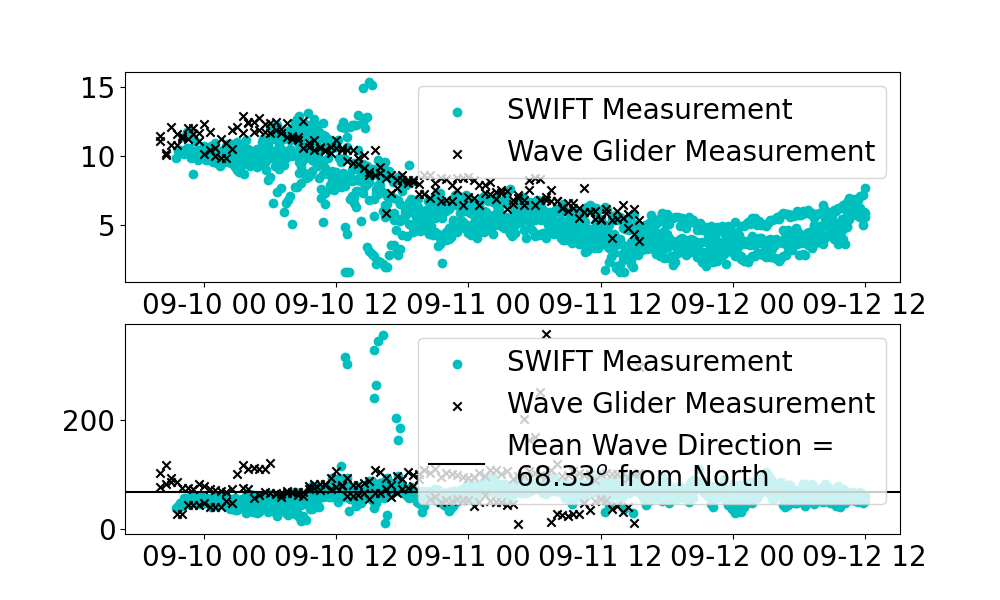

In [89]:
max_wind_spd = np.max(df['windspd'])
print(max_wind_spd)
mean_wind_dir = np.mean(df['winddir'])
print(mean_wind_dir)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), nrows=2)
ax1.scatter(pd.to_datetime(df[df['instrument_type']=='SWIFT']['time']), df[df['instrument_type']=='SWIFT']['windspd'], color='c', marker='o', label='SWIFT Measurement')
ax1.scatter(pd.to_datetime(df[df['instrument_type']=='WG']['time']), df[df['instrument_type']=='WG']['windspd'], color='k', marker='x', label='Wave Glider Measurement')
# ax1.axhline(max_wind_spd, color='k', label=f'Max Wind Speed = {np.round(max_wind_spd, 2)} m/s')
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', labelsize=20)

ax2.scatter(pd.to_datetime(df[df['instrument_type']=='SWIFT']['time']), df[df['instrument_type']=='SWIFT']['winddir'], color='c', marker='o', label='SWIFT Measurement')
ax2.scatter(pd.to_datetime(df[df['instrument_type']=='WG']['time']), df[df['instrument_type']=='WG']['winddir'], color='k', marker='x', label='Wave Glider Measurement')
ax2.axhline(np.mean(df['winddir']), color='k', label=f'Mean Wave Direction = \n {np.round(mean_wind_dir, 2)}$^o$ from North')
ax2.legend(fontsize=20)
ax2.tick_params(axis='both', labelsize=20)


## Wave Conditions

3.567638063332268
129.48148753118673


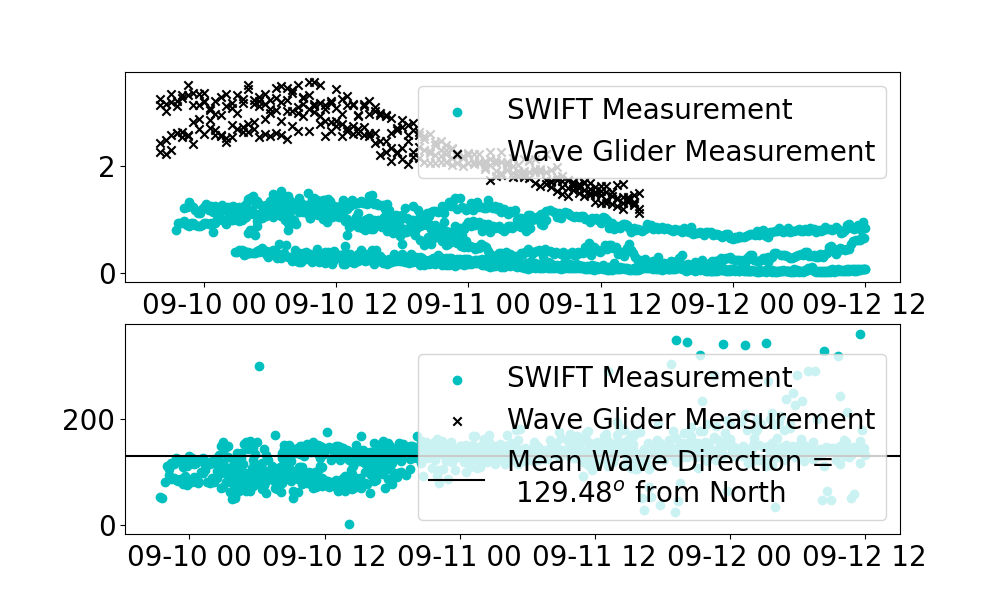

In [96]:
max_hs = np.max(df['hs'])
print(max_hs)
mean_wave_dir = np.mean(df['wave_direction'])
print(mean_wave_dir)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), nrows=2)
ax1.scatter(pd.to_datetime(df[df['instrument_type']=='SWIFT']['time']), df[df['instrument_type']=='SWIFT']['hs'], color='c', marker='o', label='SWIFT Measurement')
ax1.scatter(pd.to_datetime(df[df['instrument_type']=='WG']['time']), df[df['instrument_type']=='WG']['hs'], color='k', marker='x', label='Wave Glider Measurement')
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', labelsize=20)

ax2.scatter(pd.to_datetime(df[df['instrument_type']=='SWIFT']['time']), df[df['instrument_type']=='SWIFT']['wave_direction'], color='c', marker='o', label='SWIFT Measurement')
ax2.scatter(pd.to_datetime(df[df['instrument_type']=='WG']['time']), df[df['instrument_type']=='WG']['wave_direction'], color='k', marker='x', label='Wave Glider Measurement')
ax2.axhline(mean_wave_dir, color='k', label=f'Mean Wave Direction = \n {np.round(mean_wave_dir, 2)}$^o$ from North')
ax2.legend(fontsize=20)
ax2.tick_params(axis='both', labelsize=20)


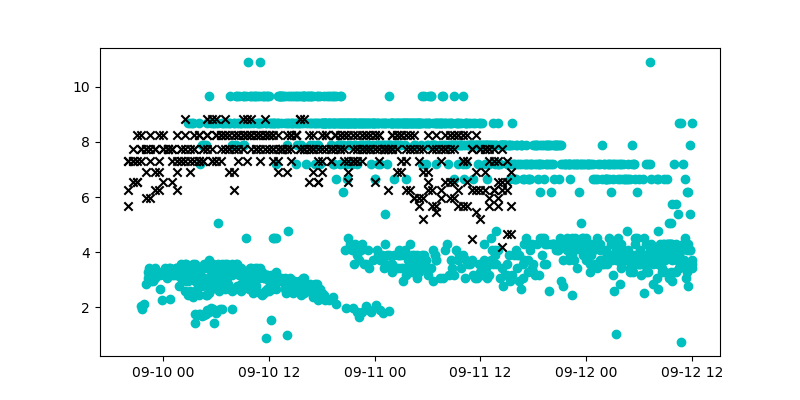

In [95]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(pd.to_datetime(df[df['instrument_type']=='SWIFT']['time']), df[df['instrument_type']=='SWIFT']['wave_period'], color='c', marker='o', label='SWIFT Measurement')
ax.scatter(pd.to_datetime(df[df['instrument_type']=='WG']['time']), df[df['instrument_type']=='WG']['wave_period'], color='k', marker='x', label='Wave Glider Measurement')
# ax.set_ylabel('Tm [s]')
# cbar = plt.colorbar(im)
# cbar.set_label('Latitude [degrees north]')

In [ ]:
fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df[df['wave_period'] > 5]['time']), df[df['wave_period'] > 5]['wave_period'])

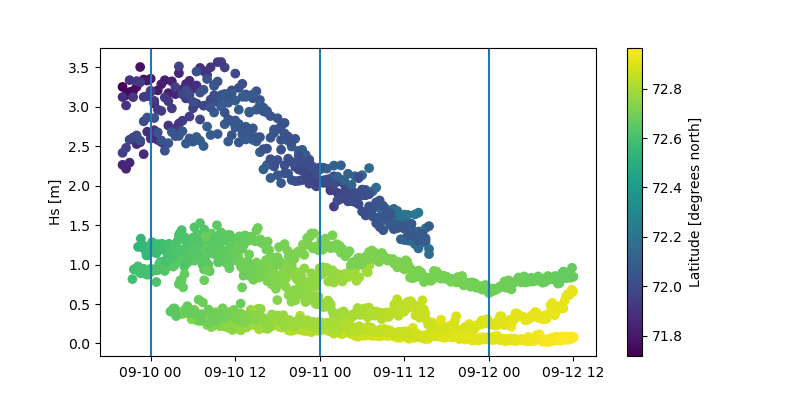

In [73]:
fig, ax = plt.subplots(figsize=(8,4))
im = ax.scatter(datetimes, df['hs'], c=df['latitude'])
cbar = plt.colorbar(im)
ax.set_ylabel('Hs [m]')
cbar.set_label('Latitude [degrees north]')
ax.axvline(datetime(2022, 9, 11))
ax.axvline(datetime(2022, 9, 10))
ax.axvline(datetime(2022, 9, 12))

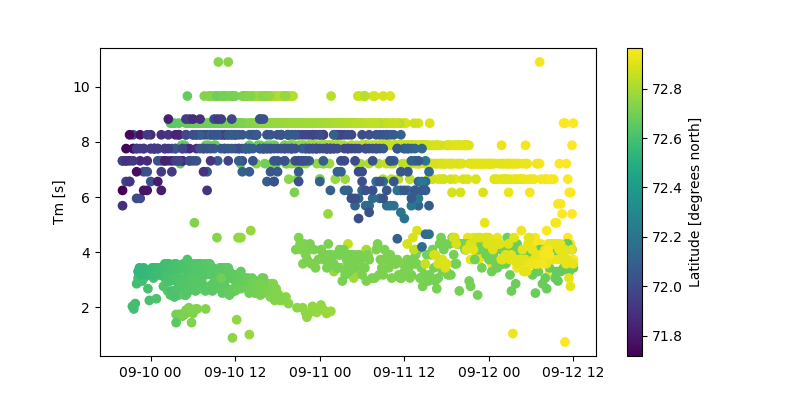

In [66]:
fig, ax = plt.subplots(figsize=(8,4))
im = ax.scatter(datetimes, df['wave_period'], c=df['latitude'])
ax.set_ylabel('Tm [s]')
cbar = plt.colorbar(im)
cbar.set_label('Latitude [degrees north]')

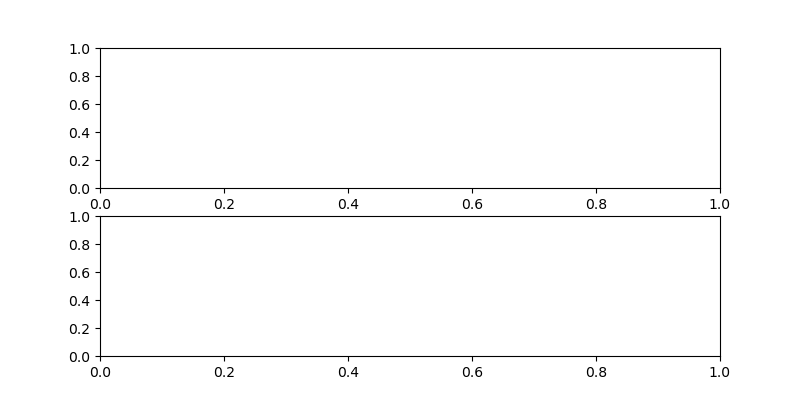

In [67]:
fig, (ax1, ax2) = plt.subplots(figsize=(8,4), nrows=2)
im = ax.scatter(datetimes, df['windspd'], c=df['latitude'])
ax.set_ylabel('Wind Speed [m/s]')
cbar = plt.colorbar(im)
cbar.set_label('Latitude [degrees north]')
ax.axvline(datetime(2022, 9, 11))
ax.axvline(datetime(2022, 9, 10))
ax.axvline(datetime(2022, 9, 12))

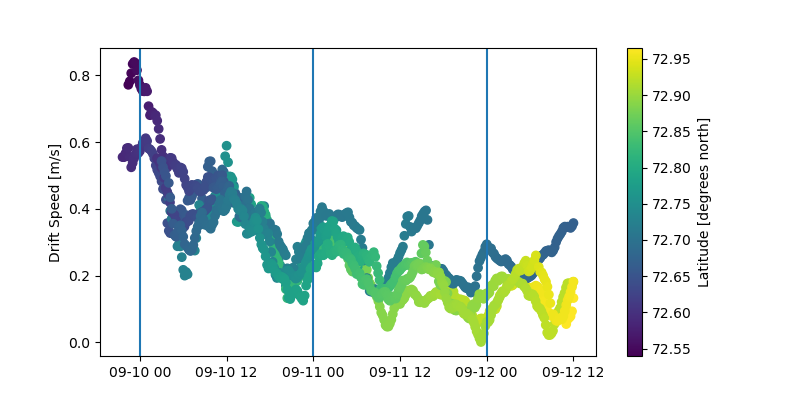

In [68]:
fig, ax = plt.subplots(figsize=(8,4))
im = ax.scatter(datetimes, df['drift_speed'], c=df['latitude'])
ax.set_ylabel('Drift Speed [m/s]')
cbar = plt.colorbar(im)
cbar.set_label('Latitude [degrees north]')
ax.axvline(datetime(2022, 9, 11))
ax.axvline(datetime(2022, 9, 10))
ax.axvline(datetime(2022, 9, 12))

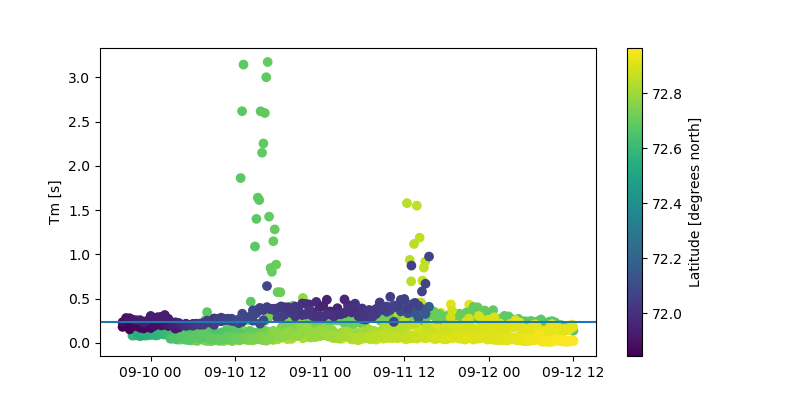

In [69]:
# Compute Fetch Laws
h_hat = 9.8 * df['hs']/df['windspd']**2
fig, ax = plt.subplots(figsize=(8,4))
im = ax.scatter(datetimes, h_hat, c=df['latitude'])
ax.set_ylabel('Tm [s]')
cbar = plt.colorbar(im)
cbar.set_label('Latitude [degrees north]')
ax.axhline(0.24)

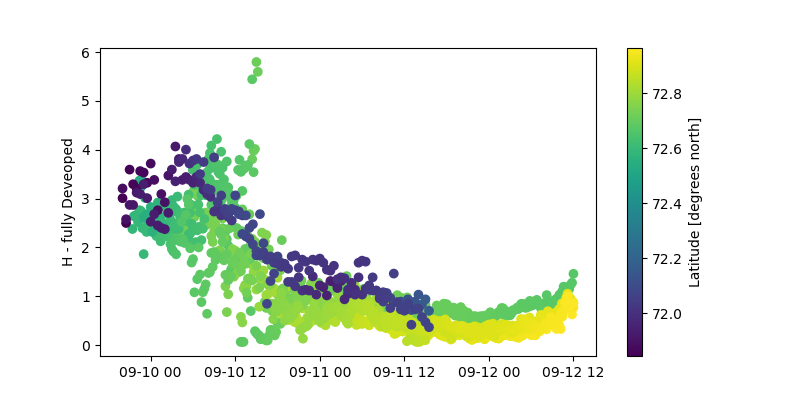

In [70]:
H_pred = 0.24 * df['windspd']**2 / 9.8
fig, ax = plt.subplots(figsize=(8,4))
im = ax.scatter(datetimes, H_pred, c=df['latitude'])
ax.set_ylabel('H - fully Deveoped')
cbar = plt.colorbar(im)
cbar.set_label('Latitude [degrees north]')

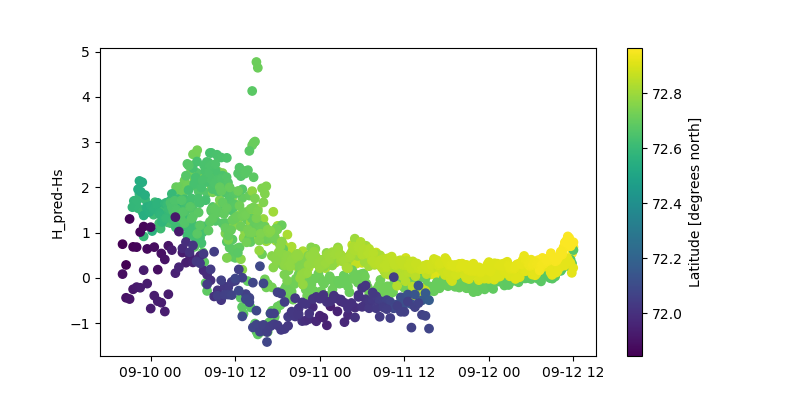

In [71]:
# Residual
fig, ax = plt.subplots(figsize=(8,4))
im = ax.scatter(datetimes, H_pred - df['hs'], c=df['latitude'])
ax.set_ylabel('H_pred-Hs')
cbar = plt.colorbar(im)
cbar.set_label('Latitude [degrees north]')

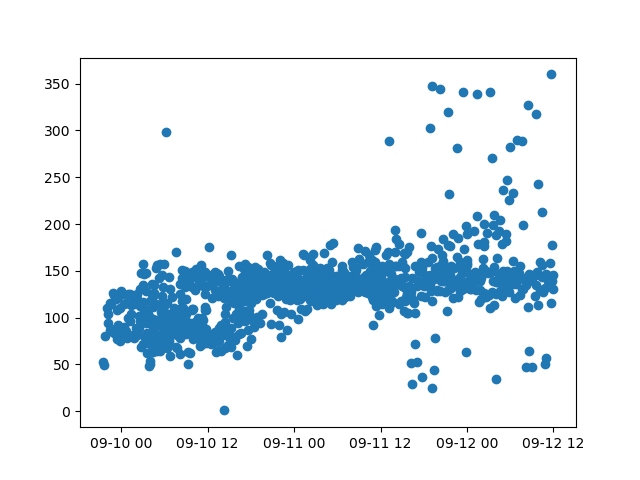

In [72]:
# Wave Direction
fig, ax = plt.subplots()
ax.scatter(datetimes, df['wave_direction'])